# Cell type specific markers in WT Arabidopsis roots

#### Working directory should contain root atlas Seurat object, which is available on GEO under record GSE152766:

    Root_Atlas.rds (or get it by running through notebook 2, 3, 4, 5, 6, 7, 8, 9, 10 & 11)
    
#### Working directory must contain subdirectories,supp_data

#### supp_data/ should contain the files, which are available on Github (github.com/Hsu-Che-Wei/COPILOT):

    features.tsv.gz
    Validated_Markers.csv

In [1]:
rm(list=ls())
# Set the working directory to where folders named after the samples are located. 
# The folder contains spliced.mtx, unspliced.mtx, barcodes and gene id files, and json files produced by scKB that documents the sequencing stats. 
setwd("/scratch/AG_Ohler/CheWei/scKB")

In [2]:
library(tidyverse)
library(Seurat)
library(RColorBrewer)
library(future)
#for 200gb ram 
options(future.globals.maxSize = 200000 * 1024^2)

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [33]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /fast/home/c/chsu/anaconda3/envs/seu3/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_US.utf-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.utf-8        LC_COLLATE=en_US.utf-8    
 [5] LC_MONETARY=en_US.utf-8    LC_MESSAGES=en_US.utf-8   
 [7] LC_PAPER=en_US.utf-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.utf-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggrepel_0.8.2        gprofiler2_0.2.0     GeneOverlap_1.26.0  
 [4] circlize_0.4.12      ComplexHeatmap_2.6.2 cowplot_1.1.0       
 [7] future_1.20.1        RColorBrewer_1.1-2   Seurat_3.1.5        
[10] forcats_0.5.0        stringr_1.4.0        dplyr_1.0.2         
[13] purrr_0.

In [3]:
# Load atlas
rc.integrated <- readRDS("./Root_Atlas.rds")

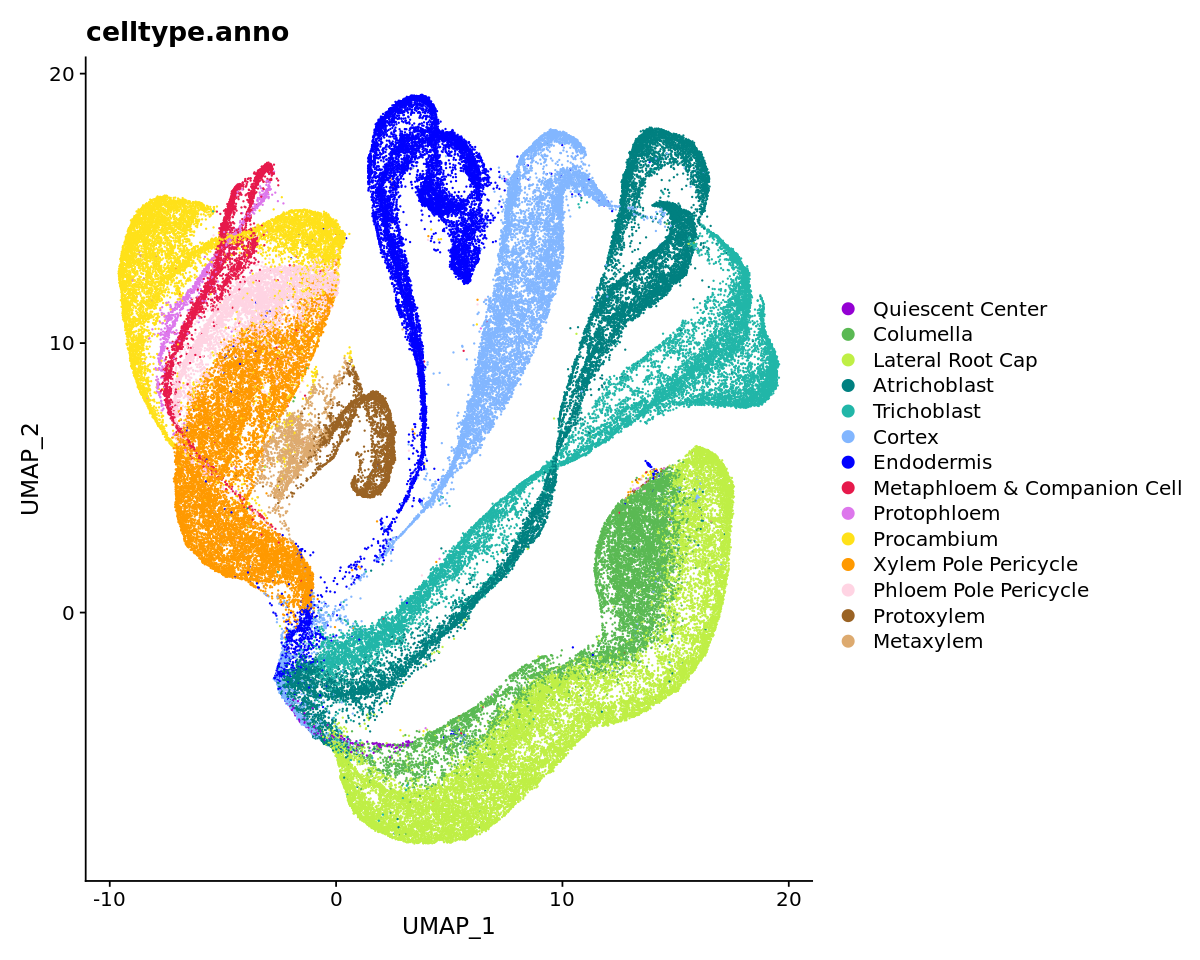

In [6]:
# Plot celltype annotation
order <- c("Quiescent Center", "Ground Tissue","Columella", "Lateral Root Cap", "Atrichoblast", "Trichoblast", "Cortex", "Endodermis", "Metaphloem & Companion Cell","Protophloem", "Xylem", "Procambium","Xylem Pole Pericycle","Phloem Pole Pericycle", "Protoxylem", "Metaxylem", "Unknown")
palette <- c("#9400d3", "#DCD0FF","#5ab953", "#bfef45", "#008080", "#21B6A8", "#82b6ff", "#0000FF","#e6194b", "#dd77ec", "#9a6324", "#ffe119", "#ff9900", "#ffd4e3", "#9a6324", "#ddaa6f", "#EEEEEE")
rc.integrated$celltype.anno <- factor(rc.integrated$celltype.anno, levels = order[sort(match(unique(rc.integrated$celltype.anno),order))]) 
color <- palette[sort(match(unique(rc.integrated$celltype.anno),order))]
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "celltype.anno", cols = color)+ggtitle("celltype.anno")

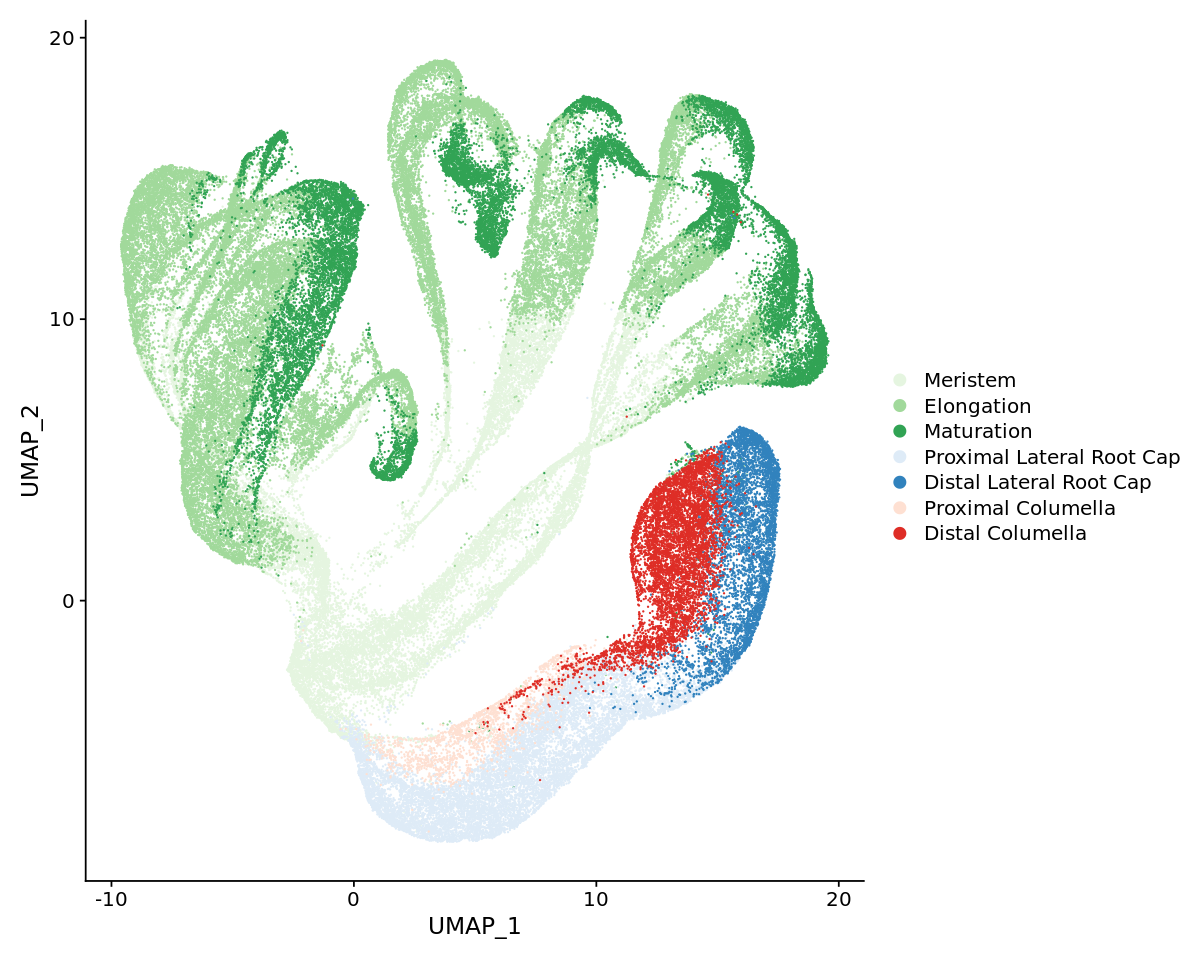

In [5]:
# Plot time
options(repr.plot.width=10, repr.plot.height=8)
DimPlot(rc.integrated, reduction = "umap", group.by = "time.anno",order = c("Distal Columella","Proximal Columella","Distal Lateral Root Cap","Proximal Lateral Root Cap","Maturation","Elongation","Meristem"),cols = c("#e5f5e0", "#a1d99b", "#31a354", "#deebf7", "#3182bd", '#fee0d2','#de2d26'))

## FindMarkers for each cell type

In [7]:
# Set the identity of interest to cell type
Idents(rc.integrated) <- "celltype.anno"
# Set the expression matrix used for DE to batch-corrected and scaled one 
DefaultAssay(rc.integrated) <- "integrated"

In [8]:
# run differentially expression (DE) analysis using ROC method, select randomly 10000 cells for each cell type
Clust_Markers <- FindAllMarkers(rc.integrated,
                                logfc.threshold=log(2),
                                min.diff.pct = 0.25,
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Quiescent Center

Calculating cluster Columella

Calculating cluster Lateral Root Cap

Calculating cluster Atrichoblast

Calculating cluster Trichoblast

Calculating cluster Cortex

Calculating cluster Endodermis

Calculating cluster Metaphloem & Companion Cell

Calculating cluster Protophloem

Calculating cluster Procambium

Calculating cluster Xylem Pole Pericycle

Calculating cluster Phloem Pole Pericycle

Calculating cluster Protoxylem

Calculating cluster Metaxylem



In [9]:
# Load in gene ids and names
feature_names <- read_tsv("./supp_data/features.tsv.gz", col_names = c("gene", "Name", "Type")) %>%
  select(-Type) %>%
  distinct()



── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  gene = col_character(),
  Name = col_character(),
  Type = col_character()
)




In [11]:
# Merge the DE output with corresponding gene id and name
Clust_Markers <- left_join(Clust_Markers, feature_names)

Joining, by = "gene"



In [12]:
# For each cell type, select the top 3 genes according to AUC score
Clust_Markers %>% group_by(cluster) %>% top_n(3, myAUC)

myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,Name
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
0.982,3.999637,0.964,0.975,0.095,Quiescent Center,AT4G35720,AT4G35720
0.980,3.754229,0.960,0.987,0.092,Quiescent Center,AT2G04025,RGF3
0.979,4.442132,0.958,0.994,0.247,Quiescent Center,AT3G51750,AT3G51750
0.963,4.482828,0.926,0.974,0.233,Columella,AT5G53460,GLT1
0.952,4.089806,0.904,0.882,0.084,Columella,AT4G15530,PPDK
0.923,2.583778,0.846,0.937,0.200,Columella,AT4G37870,PCKA
0.957,2.954451,0.914,0.967,0.155,Lateral Root Cap,AT2G41800,AT2G41800
0.924,3.273330,0.848,0.857,0.157,Lateral Root Cap,AT3G16410,NSP4
0.919,4.896697,0.838,0.773,0.052,Lateral Root Cap,AT1G54010,GLL23


In [13]:
Clust_Markers$cluster_gene <- paste(Clust_Markers$cluster, Clust_Markers$gene, sep="_")

In [14]:
# store all results 

All_clust_markers <- Clust_Markers

# subset based on AUC 0.75

Clust_Markers <- filter(Clust_Markers, myAUC>=0.75)

In [15]:
# Calculate the frequency of genes being detected as marker
(times_per_gene <- Clust_Markers %>%
ungroup() %>%
group_by(gene) %>%
tally())

gene,n
<chr>,<int>
AT1G01010,1
AT1G01070,3
AT1G01100,2
AT1G01170,1
AT1G01240,1
AT1G01300,2
AT1G01320,1
AT1G01360,1
AT1G01380,2


In [16]:
Clust_Markers <- left_join(Clust_Markers, times_per_gene)

Joining, by = "gene"



In [17]:
summary(Clust_Markers$n)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.616   2.000   6.000 

In [22]:
# Load libraries for plotting
library(cowplot)
library(ComplexHeatmap)
library(circlize)
library(GeneOverlap)
library(gprofiler2)
library(ggrepel)
library(ggplot2)

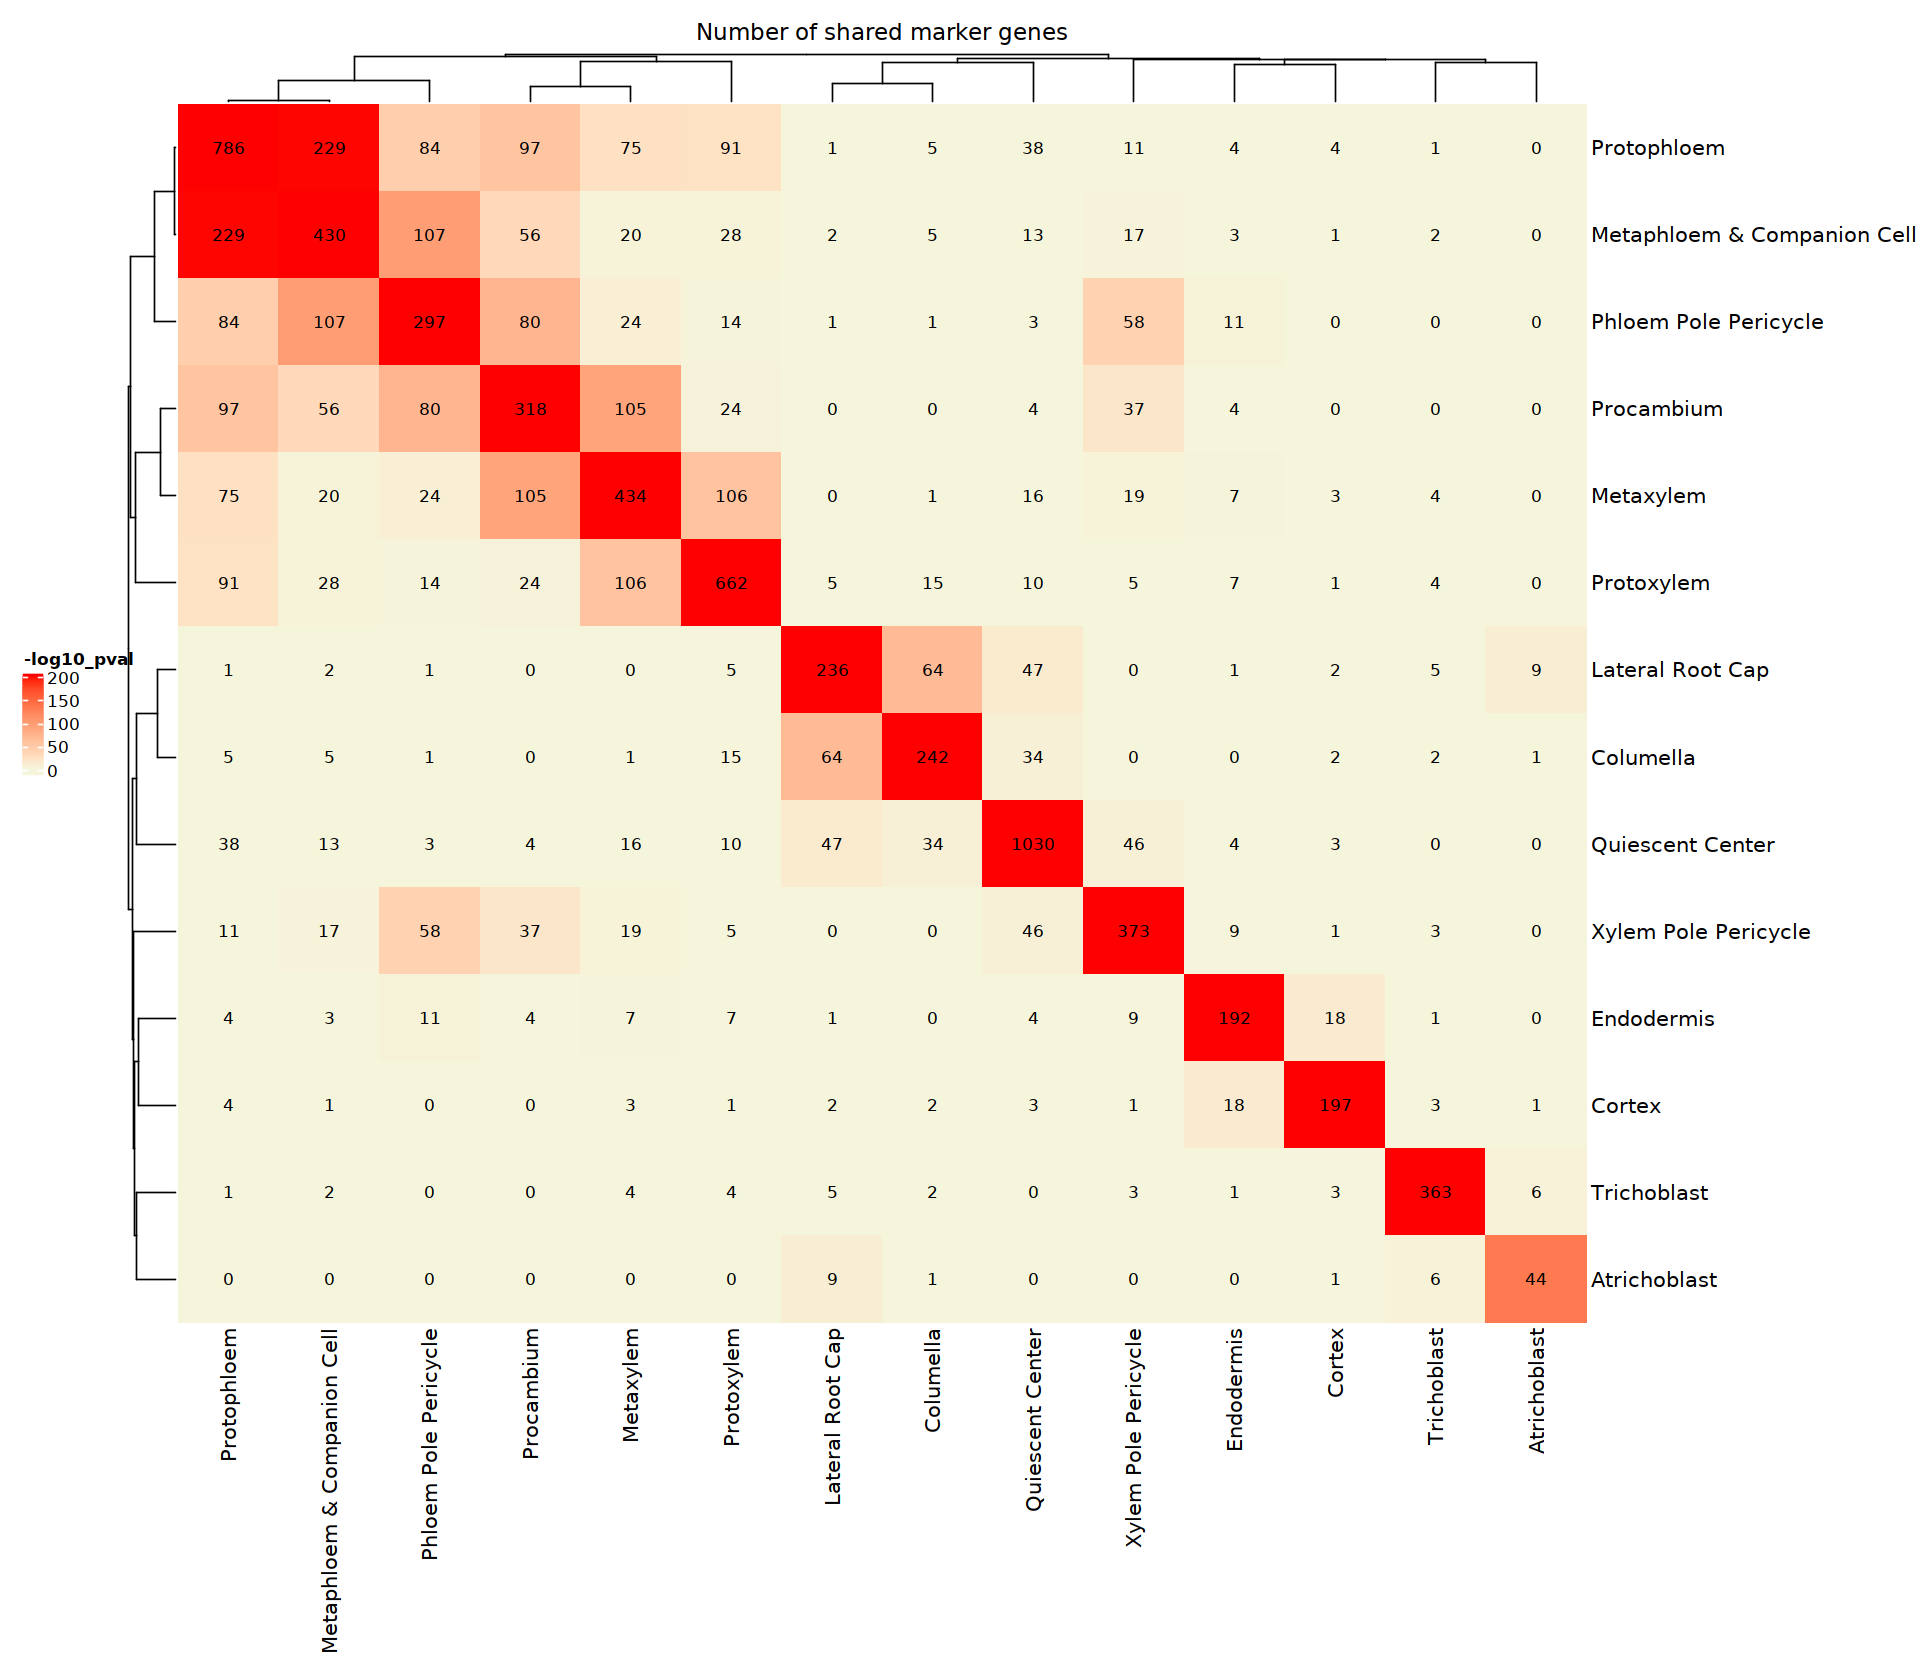

In [23]:
options(repr.plot.width = 16, repr.plot.height = 14)


markers_sel <- select(Clust_Markers, gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap 

# number of integrated features

genome_size <- 17513L

#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, 
                name = "-log10_pval", 
                col = colorRamp2(c(0, 200), 
                                 c("beige", "red")), 
                column_title = "Number of shared marker genes", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                clustering_distance_rows = "pearson",
                clustering_distance_columns = "pearson", 
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")

In [24]:
# Load GO terms for Arabidopsis thaliana
cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(query) %>%
  top_n(5, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name



Joining, by = "term_id"



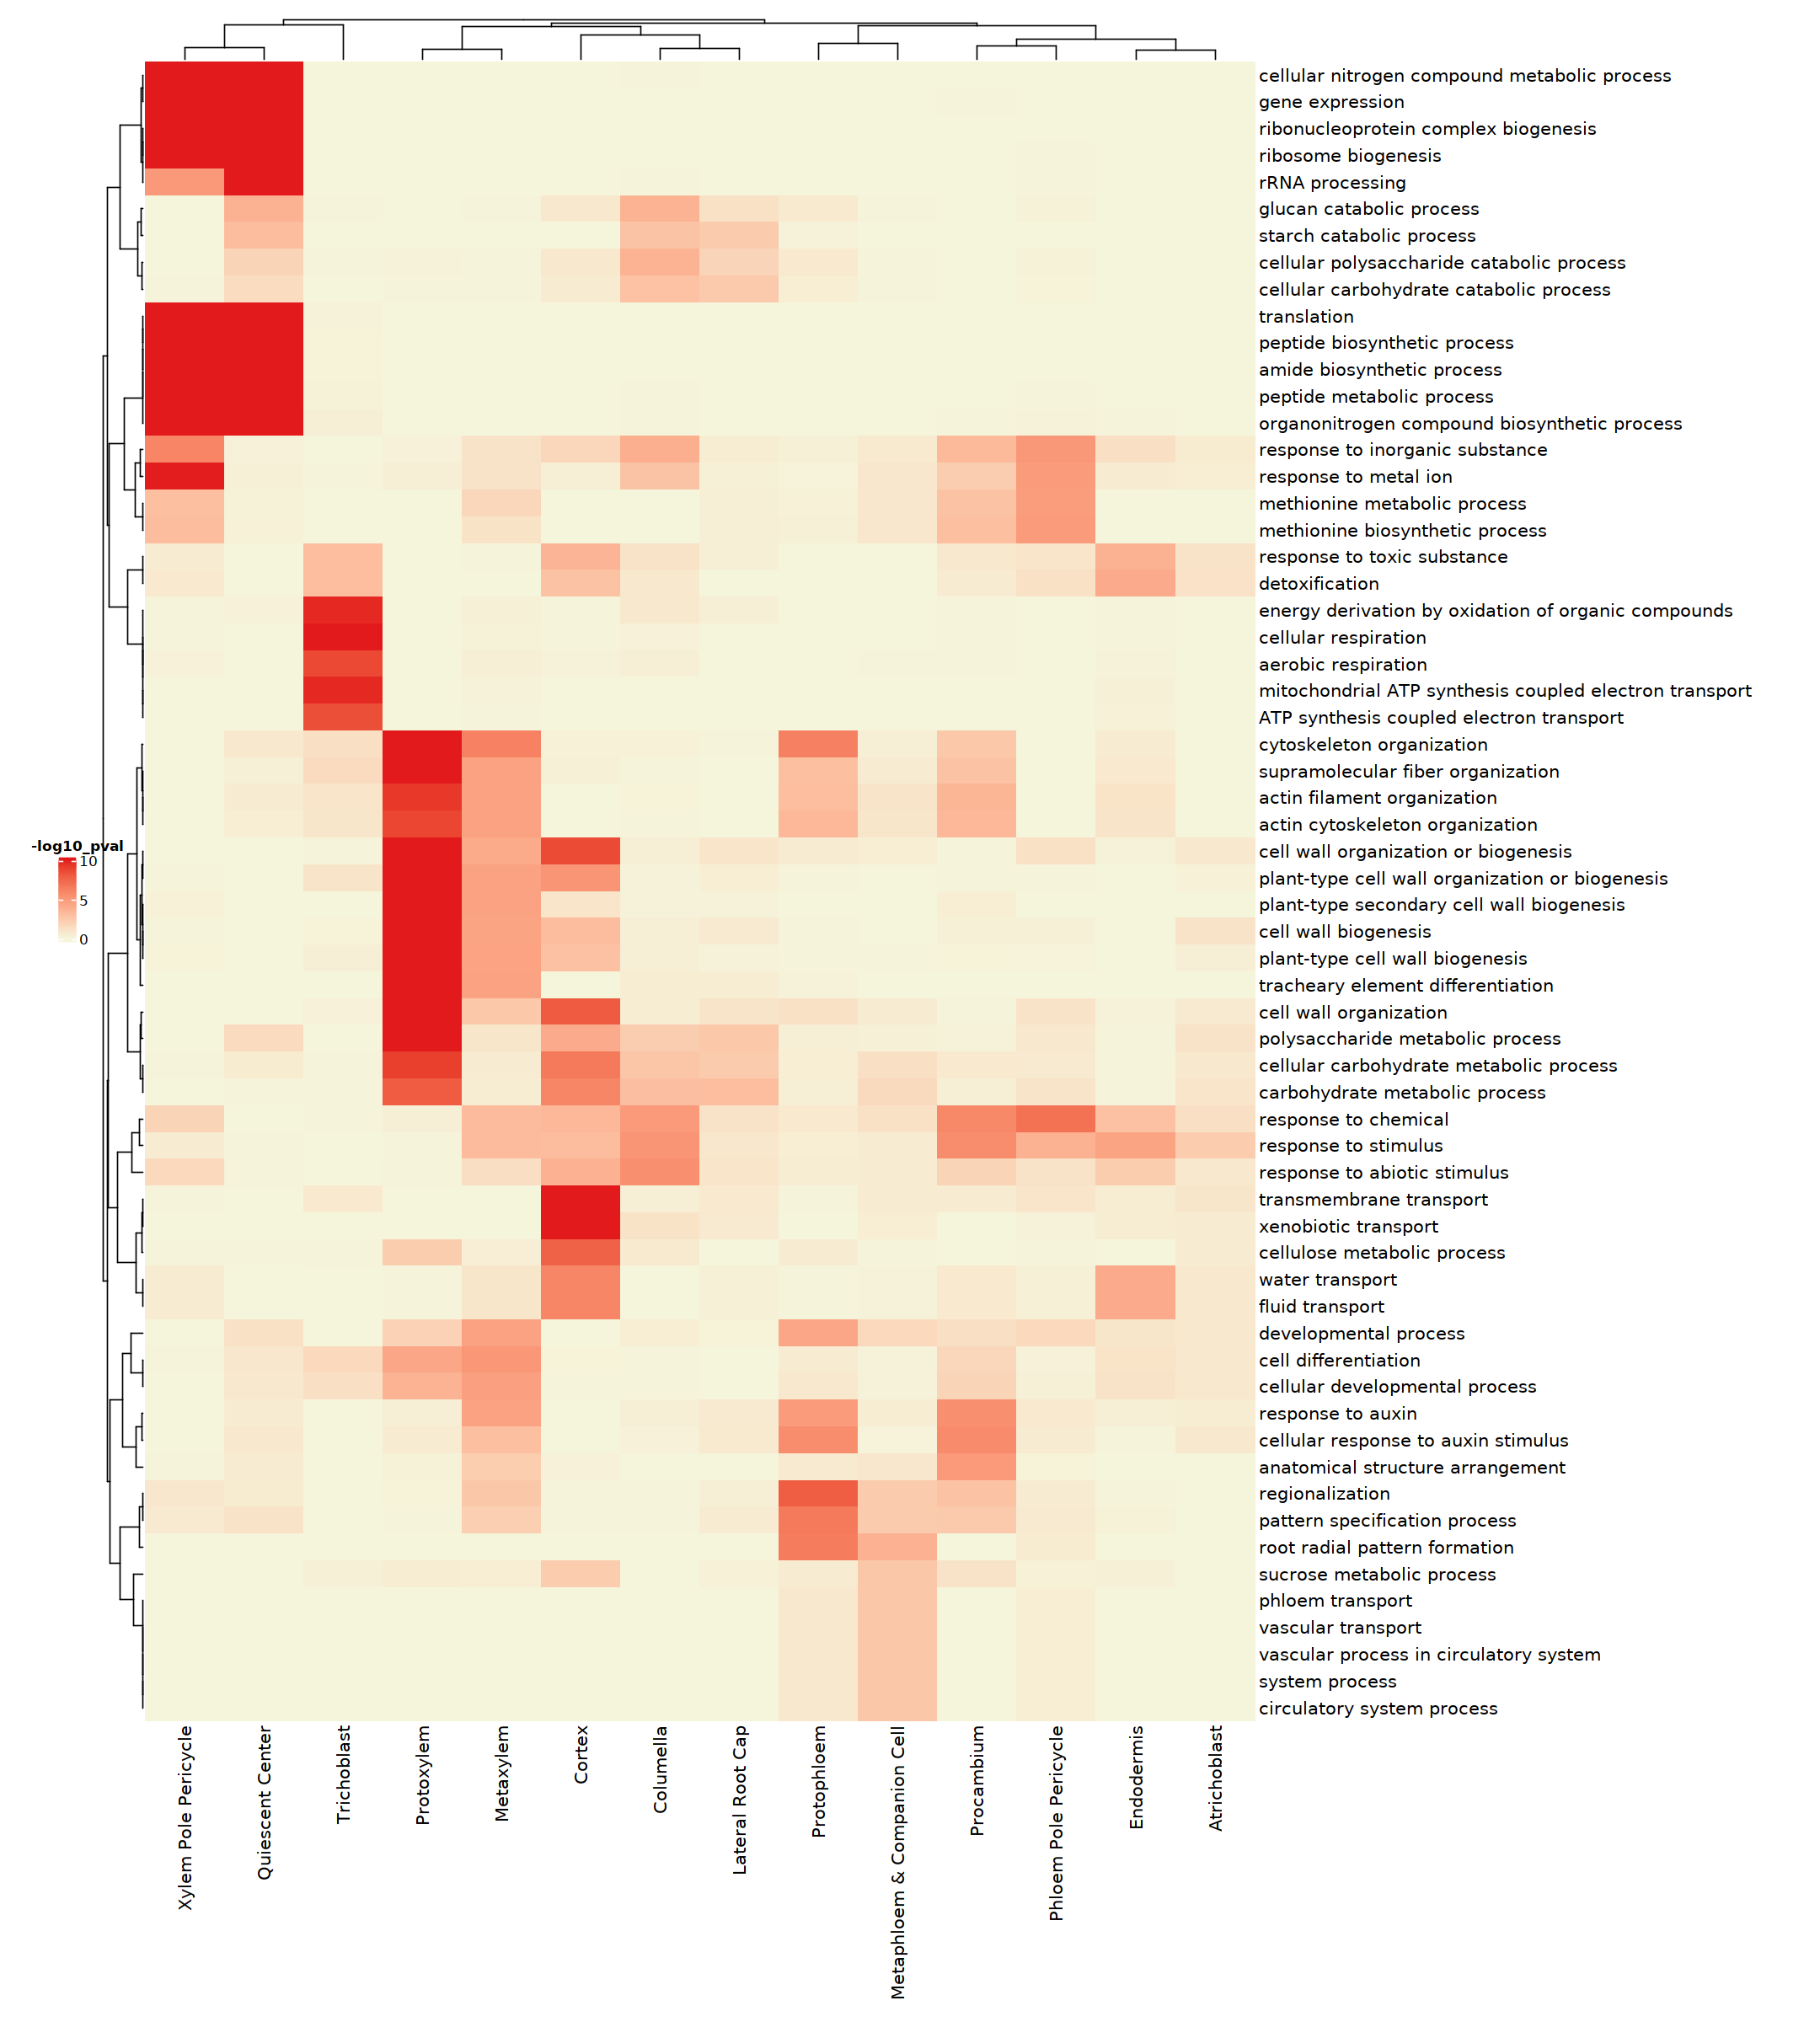

In [25]:
options(repr.plot.width = 18, repr.plot.height = 20)

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="topcenter", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 10), 
                                  c("beige", "#e31a1c")), 
                 cluster_rows = T,
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE, 
                 clustering_distance_rows = "pearson",
                 clustering_distance_columns = "pearson", 
                 row_names_gp = gpar(fontsize = 12)) 


# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")

In [26]:
# Load the known markers
(used.markers <- read_csv("./supp_data/Validated_Markers.csv"))


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  Locus = col_character(),
  Gene = col_character(),
  Celltype = col_character(),
  Source = col_character()
)




Locus,Gene,Celltype,Source
<chr>,<chr>,<chr>,<chr>
AT1G79840,GL2,Atrichoblast,"Lee et al., PNAS, 2006"
AT3G28540,AT3G28540,Columella (1-3th Outer Layer),"Wendrich et al., Science, 2020"
AT5G48130,AT5G48130,Columella (1-4th Outer Layer) + LRC (3 Vertical Layers from Columella),"Wendrich et al., Science, 2020"
AT1G17400,AT1G17400,Columella (1-5th Outer Layer),"Wendrich et al., Science, 2020"
AT1G33280,BRN1,Columella (1st Outer Layer) + LRC (1st +2nd Outer Layer),"Kamiya et al., Development, 2016"
AT4G10350,BRN2,Columella (1st Outer Layer) + LRC (1st Outer Layer),"Kamiya et al., Development, 2016"
AT1G79580,SMB,Columella + LRC,"Kamiya et al., Development, 2016"
AT1G62500,CO2,Cortex,"Heidstra et al., GenesDev, 2004"
AT1G62510,AT1G62510,Cortex,"Denyer et al., Dev Cell, 2019"


In [27]:
used.markers$cluster_gene <- paste(used.markers$Celltype, used.markers$Locus, sep="_")

In [28]:
# Combine DE output to see whether the known markers are captured
Clust_Markers <- mutate(Clust_Markers, pct.diff=pct.1-pct.2)

Clust_Markers <- arrange(Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
mutate(known_marker=cluster_gene %in% used.markers$cluster_gene) %>%
arrange(combined_rank)
Clust_Markers

myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,Name,cluster_gene,n,pct.diff,pct.diff_rank,avg_diff_rank,myAUC_rank,combined_rank,known_marker
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<lgl>
0.986,4.663276,0.972,0.984,0.066,Phloem Pole Pericycle,AT1G26450,AT1G26450,Phloem Pole Pericycle_AT1G26450,3,0.918,1,1,1,1,FALSE
0.981,7.780694,0.962,0.942,0.073,Trichoblast,AT1G23750,AT1G23750,Trichoblast_AT1G23750,1,0.869,1,2,1,1,FALSE
0.963,4.482828,0.926,0.974,0.233,Columella,AT5G53460,GLT1,Columella_AT5G53460,1,0.741,3,1,1,1,FALSE
0.917,5.269837,0.834,0.779,0.049,Lateral Root Cap,AT4G37160,sks15,Lateral Root Cap_AT4G37160,1,0.730,2,1,4,1,FALSE
0.959,5.188406,0.918,0.927,0.065,Cortex,AT1G02850,BGLU11,Cortex_AT1G02850,1,0.862,1,6,1,1,FALSE
0.943,6.467947,0.886,0.866,0.017,Endodermis,AT5G57620,MYB36,Endodermis_AT5G57620,1,0.849,3,2,4,1,TRUE
0.919,4.186106,0.838,0.854,0.063,Xylem Pole Pericycle,AT2G18800,XTH21,Xylem Pole Pericycle_AT2G18800,1,0.791,2,4,4,1,FALSE
0.867,4.657580,0.734,0.752,0.076,Atrichoblast,AT5G44585,AT5G44585,Atrichoblast_AT5G44585,1,0.676,2,4,4,1,FALSE
0.992,7.600754,0.984,0.982,0.008,Protoxylem,AT4G18780,CESA8,Protoxylem_AT4G18780,1,0.974,1,3,7,1,TRUE


In [29]:
# Store the data
write.csv(Clust_Markers, "./supp_data/Atlas_celltype_markers_ROC.csv", row.names=F)

# Specific genes by cell type and developmental stage

In [35]:
table(rc.integrated$time.celltype.anno.crude)


         Distal Columella   Distal Lateral Root Cap   Elongation_Atrichoblast 
                     6771                      5818                      4326 
        Elongation_Cortex     Elongation_Endodermis      Elongation_Pericycle 
                     4630                      6500                     10008 
        Elongation_Phloem     Elongation_Procambium    Elongation_Trichoblast 
                     2560                      6470                      2655 
         Elongation_Xylem   Maturation_Atrichoblast         Maturation_Cortex 
                     3076                      3375                      2179 
    Maturation_Endodermis      Maturation_Pericycle         Maturation_Phloem 
                     3116                      3676                       758 
    Maturation_Procambium    Maturation_Trichoblast          Maturation_Xylem 
                     2130                      4334                      1108 
    Meristem_Atrichoblast           Meristem_Cortex

In [36]:
### combination of time and cell type anno

rc.integrated$cell_time_final <- rc.integrated$time.celltype.anno.crude

In [37]:
rc.integrated$cell_time_final <- gsub("Meristem", "Meristematic", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

rc.integrated$cell_time_final <- gsub("Elongation", "Elongating", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

rc.integrated$cell_time_final <- gsub("Maturation", "Mature", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

# Meristematic-Putative Quiescent Center

rc.integrated$cell_time_final <- gsub("Meristematic-Quiescent Center", "Quiescent Center", rc.integrated$cell_time_final, ignore.case = FALSE, perl = FALSE,
     fixed = T, useBytes = FALSE)

In [38]:
table(rc.integrated$cell_time_final)


             Distal Columella       Distal Lateral Root Cap 
                         6771                          5818 
      Elongating_Atrichoblast             Elongating_Cortex 
                         4326                          4630 
        Elongating_Endodermis          Elongating_Pericycle 
                         6500                         10008 
            Elongating_Phloem         Elongating_Procambium 
                         2560                          6470 
       Elongating_Trichoblast              Elongating_Xylem 
                         2655                          3076 
          Mature_Atrichoblast                 Mature_Cortex 
                         3375                          2179 
            Mature_Endodermis              Mature_Pericycle 
                         3116                          3676 
                Mature_Phloem             Mature_Procambium 
                          758                          2130 
           Mature_Trich

In [39]:
Idents(rc.integrated) <- "cell_time_final"
DefaultAssay(rc.integrated) <- "integrated"

cell_time_Clust_Markers <- FindAllMarkers(rc.integrated,
                                logfc.threshold=log(2),
                                min.diff.pct = 0.25,
                                max.cells.per.ident = 10000,
                                only.pos=T, 
                               test.use="roc")

Calculating cluster Meristematic_Atrichoblast

Calculating cluster Elongating_Atrichoblast

Calculating cluster Elongating_Cortex

Calculating cluster Distal Columella

Calculating cluster Proximal Lateral Root Cap

Calculating cluster Mature_Cortex

Calculating cluster Elongating_Pericycle

Calculating cluster Elongating_Xylem

Calculating cluster Mature_Pericycle

Calculating cluster Elongating_Endodermis

Calculating cluster Elongating_Phloem

Calculating cluster Mature_Procambium

Calculating cluster Elongating_Procambium

Calculating cluster Mature_Trichoblast

Calculating cluster Mature_Atrichoblast

Calculating cluster Meristematic_Pericycle

Calculating cluster Distal Lateral Root Cap

Calculating cluster Meristematic_Endodermis

Calculating cluster Meristematic_Trichoblast

Calculating cluster Meristematic_Cortex

Calculating cluster Meristematic_Phloem

Calculating cluster Proximal Columella

Calculating cluster Mature_Xylem

Calculating cluster Mature_Phloem

Calculating clu

In [40]:
cell_time_Clust_Markers

,myAUC,avg_diff,power,pct.1,pct.2,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
AT5G42630,0.937,3.384546,0.874,0.934,0.162,Meristematic_Atrichoblast,AT5G42630
AT4G22230,0.930,4.351097,0.860,0.894,0.125,Meristematic_Atrichoblast,AT4G22230
AT5G44585,0.925,3.972346,0.850,0.883,0.118,Meristematic_Atrichoblast,AT5G44585
AT2G24400,0.922,2.494442,0.844,0.929,0.164,Meristematic_Atrichoblast,AT2G24400
AT1G31950,0.921,2.737705,0.842,0.919,0.171,Meristematic_Atrichoblast,AT1G31950
AT2G20800,0.920,2.824591,0.840,0.914,0.191,Meristematic_Atrichoblast,AT2G20800
AT4G31320,0.911,2.369432,0.822,0.933,0.250,Meristematic_Atrichoblast,AT4G31320
AT5G40330,0.907,3.689132,0.814,0.872,0.167,Meristematic_Atrichoblast,AT5G40330
AT1G54890,0.903,4.592964,0.806,0.850,0.113,Meristematic_Atrichoblast,AT1G54890


In [41]:
cell_time_Clust_Markers %>%
group_by(cluster) %>%
tally()

cluster,n
<fct>,<int>
Meristematic_Atrichoblast,580
Elongating_Atrichoblast,380
Elongating_Cortex,567
Distal Columella,495
Proximal Lateral Root Cap,554
Mature_Cortex,525
Elongating_Pericycle,440
Elongating_Xylem,700
Mature_Pericycle,493


In [42]:
cell_time_Clust_Markers %>%
filter(myAUC>=0.75) %>%
group_by(cluster) %>%
tally()

cluster,n
<fct>,<int>
Meristematic_Atrichoblast,343
Elongating_Atrichoblast,280
Elongating_Cortex,352
Distal Columella,287
Proximal Lateral Root Cap,312
Mature_Cortex,313
Elongating_Pericycle,204
Elongating_Xylem,461
Mature_Pericycle,325


In [43]:
# store all 

all_cell_time_Clust_Markers <- cell_time_Clust_Markers

In [44]:
# keep only markers 0.75 and above
cell_time_Clust_Markers <- filter(cell_time_Clust_Markers, myAUC>=0.75)

In [45]:
(times_per_gene <- cell_time_Clust_Markers %>%
ungroup() %>%
group_by(gene) %>%
tally())

gene,n
<chr>,<int>
AT1G01010,2
AT1G01050,2
AT1G01070,2
AT1G01090,2
AT1G01100,5
AT1G01110,2
AT1G01120,1
AT1G01170,1
AT1G01180,3


In [46]:
cell_time_Clust_Markers <- left_join(cell_time_Clust_Markers, times_per_gene)

Joining, by = "gene"



In [47]:
cell_time_Clust_Markers <- left_join(cell_time_Clust_Markers, feature_names)

Joining, by = "gene"



In [48]:
cell_time_Clust_Markers$cluster_gene <- paste(cell_time_Clust_Markers$cluster, Clust_Markers$gene, sep="_")

## Rank AUC dataset for celltype/dev combo

In [49]:
cell_time_Clust_Markers <- mutate(cell_time_Clust_Markers, pct.diff=pct.1-pct.2)
cell_time_Clust_Markers

myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,n,Name,cluster_gene,pct.diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<int>,<chr>,<chr>,<dbl>
0.937,3.384546,0.874,0.934,0.162,Meristematic_Atrichoblast,AT5G42630,2,KAN4,Meristematic_Atrichoblast_AT1G26450,0.772
0.930,4.351097,0.860,0.894,0.125,Meristematic_Atrichoblast,AT4G22230,1,AT4G22230,Meristematic_Atrichoblast_AT1G23750,0.769
0.925,3.972346,0.850,0.883,0.118,Meristematic_Atrichoblast,AT5G44585,2,AT5G44585,Meristematic_Atrichoblast_AT5G53460,0.765
0.922,2.494442,0.844,0.929,0.164,Meristematic_Atrichoblast,AT2G24400,2,AT2G24400,Meristematic_Atrichoblast_AT4G37160,0.765
0.921,2.737705,0.842,0.919,0.171,Meristematic_Atrichoblast,AT1G31950,2,AT1G31950,Meristematic_Atrichoblast_AT1G02850,0.748
0.920,2.824591,0.840,0.914,0.191,Meristematic_Atrichoblast,AT2G20800,1,NDB4,Meristematic_Atrichoblast_AT5G57620,0.723
0.911,2.369432,0.822,0.933,0.250,Meristematic_Atrichoblast,AT4G31320,2,AT4G31320,Meristematic_Atrichoblast_AT2G18800,0.683
0.907,3.689132,0.814,0.872,0.167,Meristematic_Atrichoblast,AT5G40330,2,MYB23,Meristematic_Atrichoblast_AT5G44585,0.705
0.903,4.592964,0.806,0.850,0.113,Meristematic_Atrichoblast,AT1G54890,1,AT1G54890,Meristematic_Atrichoblast_AT4G18780,0.737


In [50]:
cell_time_Clust_Markers <- arrange(cell_time_Clust_Markers, desc(pct.diff)) %>%
group_by(cluster) %>%
mutate(pct.diff_rank=dplyr::row_number()) %>%
arrange(desc(avg_diff)) %>%
mutate(avg_diff_rank=dplyr::row_number()) %>%
arrange(desc(myAUC)) %>%
mutate(myAUC_rank=dplyr::row_number()) %>%
mutate(combined_rank_raw=(pct.diff_rank + avg_diff_rank + myAUC_rank)/3) %>%
arrange(combined_rank_raw) %>%
mutate(combined_rank=dplyr::row_number()) %>%
select(-combined_rank_raw) %>%
arrange(combined_rank)
cell_time_Clust_Markers

myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,n,Name,cluster_gene,pct.diff,pct.diff_rank,avg_diff_rank,myAUC_rank,combined_rank
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>
0.981,4.939003,0.962,0.968,0.059,Elongating_Procambium,AT4G14650,2,AT4G14650,Elongating_Procambium_AT3G29350,0.909,1,2,1,1
0.978,4.448936,0.956,0.960,0.084,Distal Columella,AT1G05010,1,ACO4,Distal Columella_AT1G30900,0.876,1,2,2,1
0.973,4.222804,0.946,0.968,0.071,Elongating_Cortex,AT1G62510,2,AT1G62510,Elongating_Cortex_AT5G65670,0.897,1,2,2,1
0.965,4.673547,0.930,0.957,0.081,Mature_Pericycle,AT5G43180,1,AT5G43180,Mature_Pericycle_AT5G20700,0.876,2,1,3,1
0.970,3.866516,0.940,0.937,0.073,Proximal Lateral Root Cap,AT1G54010,1,GLL23,Proximal Lateral Root Cap_AT2G27740,0.864,1,5,1,1
0.989,5.619999,0.978,0.986,0.050,Elongating_Endodermis,AT4G22110,1,AT4G22110,Elongating_Endodermis_AT2G16930,0.936,3,1,4,1
0.946,3.992237,0.892,0.915,0.097,Mature_Procambium,AT1G61660,2,BHLH112,Mature_Procambium_AT3G60320,0.818,3,2,3,1
0.981,4.515722,0.962,0.981,0.070,Meristematic_Phloem,AT2G39830,2,DAR2,Meristematic_Phloem_AT5G48000,0.911,7,1,2,1
0.930,4.351097,0.860,0.894,0.125,Meristematic_Atrichoblast,AT4G22230,1,AT4G22230,Meristematic_Atrichoblast_AT1G23750,0.769,3,5,2,1


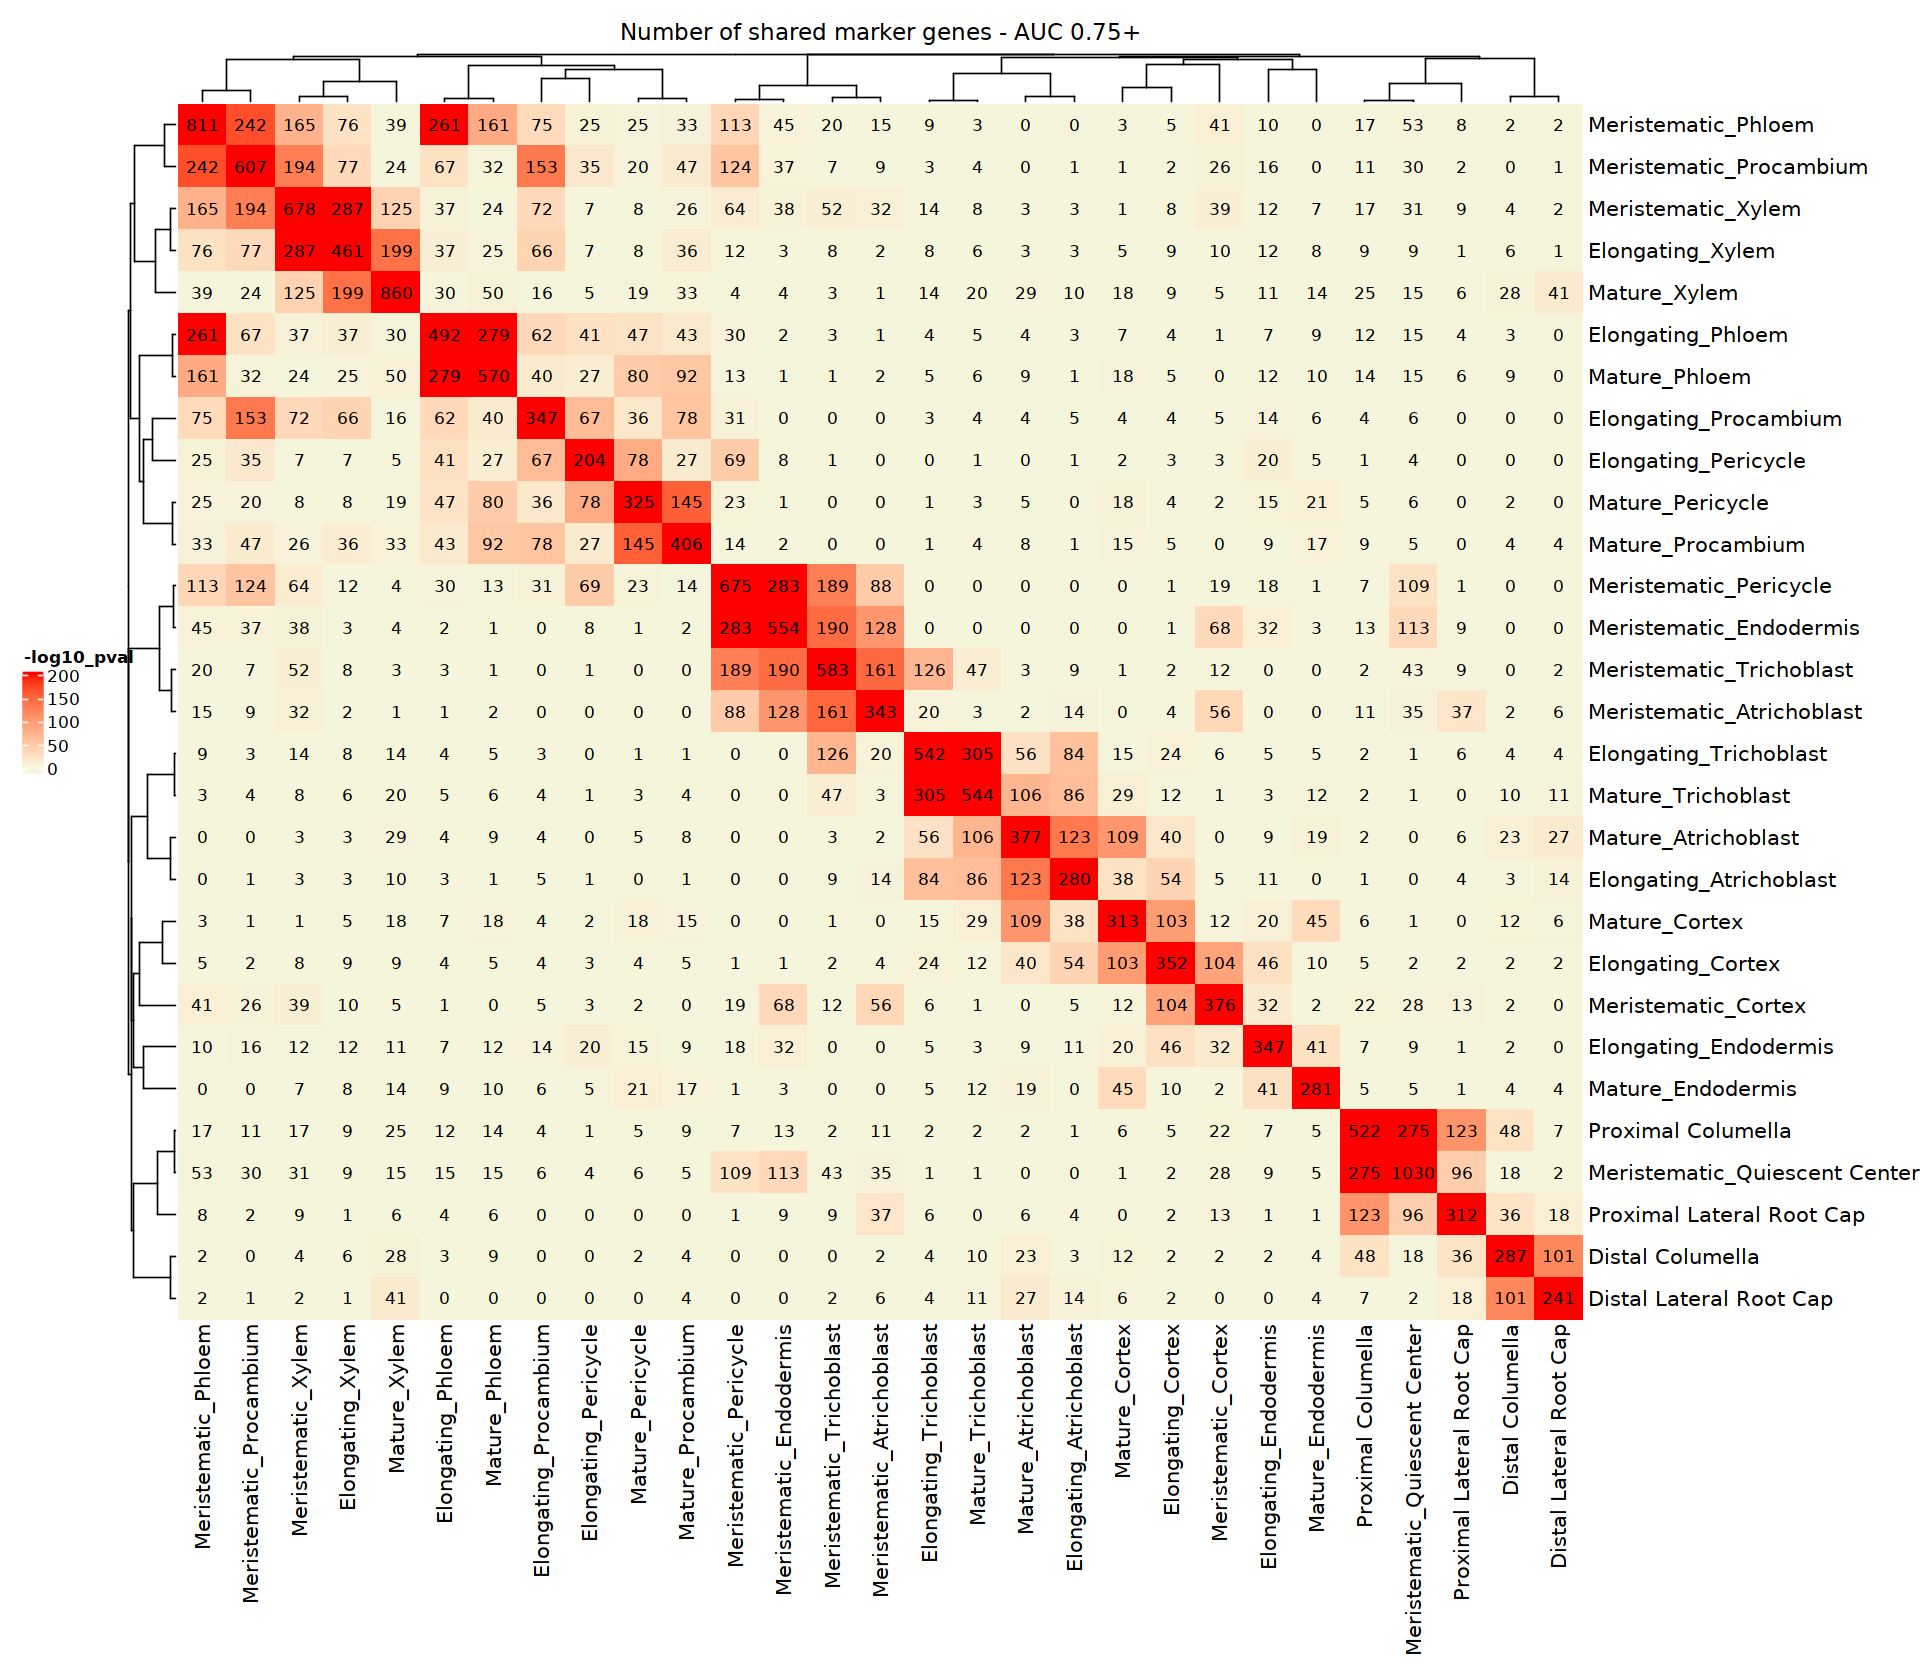

In [51]:
options(repr.plot.width = 16, repr.plot.height = 14)


markers_sel <- filter(cell_time_Clust_Markers, myAUC>=0.75) %>% select(gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))
 
## GeneOverlap 

# number of integrated features

genome_size <- 17513L

#compare all lists
gom.self <- newGOM(markers_list, markers_list, genome.size=genome_size)


int <- getNestedList(gom.self, "intersection")
int_matrix <- getMatrix(gom.self, "intersection")
p.val <- getMatrix(gom.self, "pval")
JC <- getMatrix(gom.self, "Jaccard")

# log of p.val for intersection
p.val_log <- -log10(p.val + 1e-200)


olap <- Heatmap(p.val_log, 
                name = "-log10_pval", 
                col = colorRamp2(c(0, 200), 
                                 c("beige", "red")), 
                column_title = "Number of shared marker genes - AUC 0.75+", 
                cluster_rows = T,
                cluster_columns = T, 
                use_raster= FALSE, 
                show_column_names = TRUE, 
                show_row_names = TRUE, 
                show_row_dend = TRUE, 
                clustering_distance_rows = "pearson",
                clustering_distance_columns = "pearson", 
                show_column_dend = TRUE, cell_fun = function(j, i, x, y, width, height, fill) {grid.text(sprintf("%.0f", int_matrix[i, j]), x, y, gp = gpar(fontsize = 10))
}) 
                        
                        # padding - bottom, left, top, right
draw(olap, padding = unit(c(15, 5, 5, 10), "mm"), heatmap_legend_side = "left")

In [52]:

markers_sel <- filter(cell_time_Clust_Markers, myAUC>=0.75) %>% select(gene, cluster)

markers_list <- split(markers_sel, f=markers_sel$cluster)
 
#this makes list from long df of gene lists - TARGET is what we want to keep
markers_list  <- lapply(markers_list, function(x) x[names(x)=="gene"])
# convert each sublist into character and eliminate duplicates
markers_list  <- lapply(markers_list, function(x) as.character(unique(x$gene)))

cluster_GO <- gost(markers_list, organism = "athaliana", correction_method = "fdr", significant = F, multi_query = F)

cluster_GO_df <- cluster_GO[[1]]

cluster_GO_sig <- filter(cluster_GO_df, p_value<=0.01)

# top  terms for each cluster

cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(query) %>%
  top_n(5, wt = -p_value) %>%
  arrange(desc(p_value)) -> top_GO

GO_n <- cluster_GO_sig %>%
  filter(source=="GO:BP", intersection_size>=4) %>%
  group_by(term_id) %>%
  tally() %>%
  arrange(desc(n))


GO_n <- dplyr::rename(GO_n, "n_clusters"=n)

cluster_GO_sig_n <- left_join(cluster_GO_sig, GO_n)

# get all terms for the top ones so that all clusters have values

top_GO_all <- filter(cluster_GO_df, term_id %in% top_GO$term_id)


#spread and plot


top_GO_sel <- select(top_GO_all, query, p_value, term_id, term_name)

spread_GO <- spread(top_GO_sel, key = query, p_value)

spread_GO[is.na(spread_GO)] <- 1

spread_GO_m <- as.matrix(-log10(spread_GO[3:ncol(spread_GO)]))
rownames(spread_GO_m) <- spread_GO$term_name



Joining, by = "term_id"



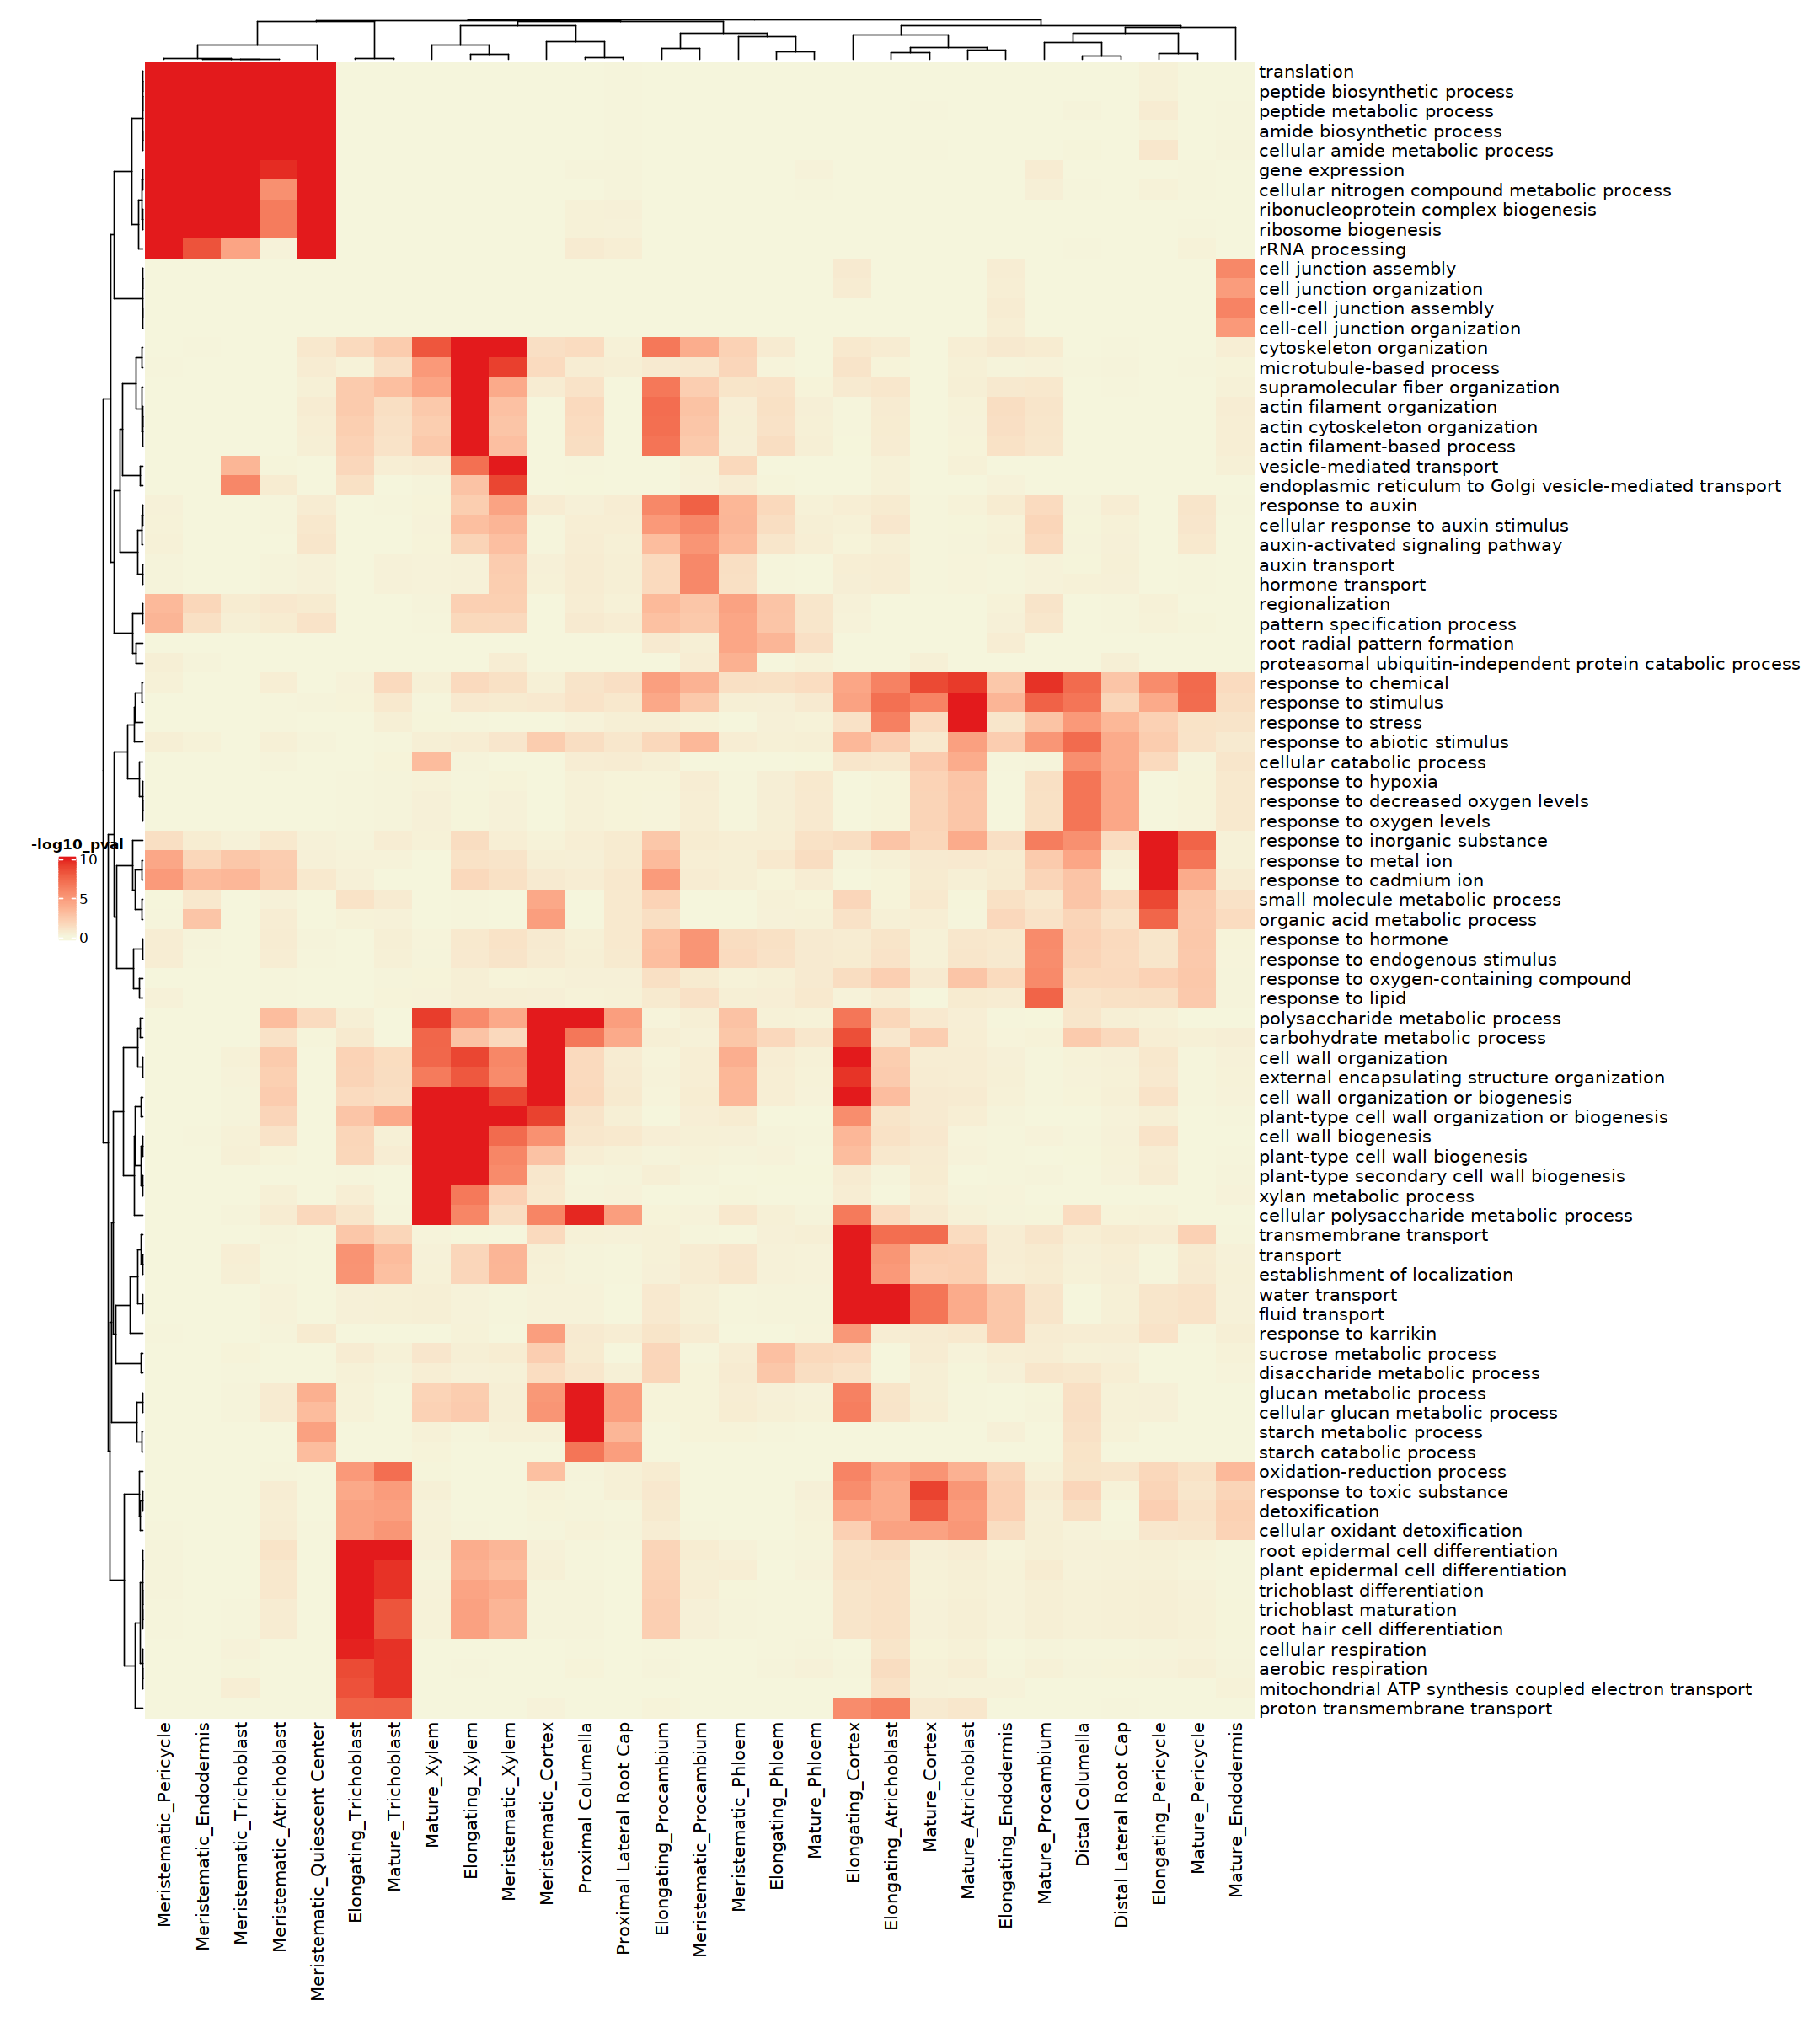

In [53]:
options(repr.plot.width = 18, repr.plot.height = 20)

GO_hm <- Heatmap(spread_GO_m, 
                 name = "-log10_pval", 
                 heatmap_legend_param = list(title_position="topcenter", color_bar = "continuous"), 
                 col = colorRamp2(c(0, 10), 
                                  c("beige", "#e31a1c")), 
                 cluster_rows = T,
                 cluster_columns = T, 
                 use_raster= FALSE, 
                 show_column_names = TRUE, 
                 show_row_names = TRUE, 
                 show_row_dend = TRUE, 
                 show_column_dend = TRUE, 
                 clustering_distance_rows = "pearson",
                 clustering_distance_columns = "pearson", 
                 row_names_gp = gpar(fontsize = 12)) 


# padding - bottom, left, top, right
draw(GO_hm, padding = unit(c(15, 15, 5, 80), "mm"), heatmap_legend_side = "left")

In [54]:
cell_time_Clust_Markers$clus_to_split <- cell_time_Clust_Markers$cluster
cell_time_Clust_Markers <- separate(cell_time_Clust_Markers, clus_to_split, into=c("timezone", "celltype"), sep="-")


Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 13720 rows [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, ...].”


In [55]:
cell_time_Clust_Markers$cluster <- as.character(cell_time_Clust_Markers$cluster)


cell_time_Clust_Markers$timezone <- factor(cell_time_Clust_Markers$timezone, levels=c("Mature", "Elongating", "Meristematic"))

ct_levels <- names(table(rc.integrated$celltype.anno))

cell_time_Clust_Markers$celltype <- factor(cell_time_Clust_Markers$celltype, levels=ct_levels)

cell_time_Clust_Markers <- arrange(cell_time_Clust_Markers, timezone) %>% arrange(celltype)


cell_time_Clust_Markers

myAUC,avg_diff,power,pct.1,pct.2,cluster,gene,n,Name,cluster_gene,pct.diff,pct.diff_rank,avg_diff_rank,myAUC_rank,combined_rank,timezone,celltype
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<int>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<fct>,<fct>
0.981,4.939003,0.962,0.968,0.059,Elongating_Procambium,AT4G14650,2,AT4G14650,Elongating_Procambium_AT3G29350,0.909,1,2,1,1,NA,NA
0.978,4.448936,0.956,0.960,0.084,Distal Columella,AT1G05010,1,ACO4,Distal Columella_AT1G30900,0.876,1,2,2,1,NA,NA
0.973,4.222804,0.946,0.968,0.071,Elongating_Cortex,AT1G62510,2,AT1G62510,Elongating_Cortex_AT5G65670,0.897,1,2,2,1,NA,NA
0.965,4.673547,0.930,0.957,0.081,Mature_Pericycle,AT5G43180,1,AT5G43180,Mature_Pericycle_AT5G20700,0.876,2,1,3,1,NA,NA
0.970,3.866516,0.940,0.937,0.073,Proximal Lateral Root Cap,AT1G54010,1,GLL23,Proximal Lateral Root Cap_AT2G27740,0.864,1,5,1,1,NA,NA
0.989,5.619999,0.978,0.986,0.050,Elongating_Endodermis,AT4G22110,1,AT4G22110,Elongating_Endodermis_AT2G16930,0.936,3,1,4,1,NA,NA
0.946,3.992237,0.892,0.915,0.097,Mature_Procambium,AT1G61660,2,BHLH112,Mature_Procambium_AT3G60320,0.818,3,2,3,1,NA,NA
0.981,4.515722,0.962,0.981,0.070,Meristematic_Phloem,AT2G39830,2,DAR2,Meristematic_Phloem_AT5G48000,0.911,7,1,2,1,NA,NA
0.930,4.351097,0.860,0.894,0.125,Meristematic_Atrichoblast,AT4G22230,1,AT4G22230,Meristematic_Atrichoblast_AT1G23750,0.769,3,5,2,1,NA,NA


In [56]:
write.csv(cell_time_Clust_Markers, "./supp_data/Atlas_cell_time_combined_ROC_Clust_Markers.csv", row.names=F)